<a href="https://colab.research.google.com/github/jescalada/Tensorflow-colabs/blob/main/transfer_learning_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tuning
In order to fine-tune our feature-extraction models, we can unfreeze some of the layers and retrain them on our custom dataset. This can increase accuracy for our particular use case.

## Creating/importing helper functions

We can import the functions instead of creating them each time:

In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-09-17 00:53:02--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-09-17 00:53:02 (76.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir


## Getting some data
We can use pretrained models in tf.keras.applications and apply to our own problem:

In [3]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2023-09-17 00:53:07--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.207, 64.233.170.207, 142.251.175.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  26.1MB/s    in 6.7s    

2023-09-17 00:53:14 (24.0 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [4]:
unzip_data("10_food_classes_10_percent.zip")

In [5]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [6]:
# Create training and test directory paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [7]:
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical",
                                                                batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [8]:
train_data_10_percent

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [9]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [10]:
# See an example of a batch of data
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[ 21.17347    16.17347    12.403061 ]
   [ 20.790817   18.454082   13.4540825]
   [ 19.857143   18.637756   14.72449  ]
   ...
   [ 13.214264   14.         15.571472 ]
   [ 14.         14.         13.857117 ]
   [ 17.         13.         11.285645 ]]

  [[ 18.168367   14.168366   13.739796 ]
   [ 19.918367   15.984694   12.984694 ]
   [ 20.89796     9.071427    2.6887736]
   ...
   [ 13.943876   14.         15.173553 ]
   [ 14.         14.         13.989794 ]
   [ 17.         13.         11.285645 ]]

  [[ 15.153061   13.07653    17.219389 ]
   [ 17.571426   12.045917    9.530609 ]
   [ 38.408165   15.27041     3.8724494]
   ...
   [ 14.306091   13.954086   15.142944 ]
   [ 14.         14.         14.397954 ]
   [ 15.561279   13.71936    12.       ]]

  ...

  [[ 13.77041    12.341882    8.127618 ]
   [ 22.469368   17.5561     13.199001 ]
   [ 32.454308   16.219666    6.9593787]
   ...
   [ 48.728718   48.300186   50.514454 ]
   [ 18.887915   18.887915   20.887915 ]
   [ 

# Keras Functional API vs Sequential API
The Sequential API allows us to have the data flowing through each layer sequentially as defined from the constructor. The functional API allows us to build more sophisticated models by mixing and matching the inputs and outputs

## Model 0: Keras Functional API Transfer Learning

In [11]:
# 1. Create base model
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

# 2. Freeze the base model (to prevent the pretrained patterns from changing)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using ResNet50V2 you will need to normalize inputs (not required for EfficientNet as it auto-rescales)
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)

# 6. Average pool the outputs of the base model (aggregate all the most important info and reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 10. Fit the model and save the history
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=10,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data,
                                 validation_steps=int(0.25 * len(test_data)),
                                 callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                        experiment_name="10_percent_feature_extraction")])

24274472/24274472 [==============================] - 2s 0us/step
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20230917-005332
Epoch 1/10
24/24 [==============================] - 30s 256ms/step - loss: 1.9880 - accuracy: 0.3440 - val_loss: 1.3691 - val_accuracy: 0.6924
Epoch 2/10
24/24 [==============================] - 5s 163ms/step - loss: 1.2036 - accuracy: 0.7013 - val_loss: 0.9164 - val_accuracy: 0.7977
Epoch 3/10
24/24 [==============================] - 4s 170ms/step - loss: 0.8775 - accuracy: 0.8133 - val_loss: 0.7255 - val_accuracy: 0.8421
Epoch 4/10
24/24 [==============================] - 4s 171ms/step - loss: 0.7025 - accuracy: 0.8560 - val_loss: 0.6093 - val_accuracy: 0.8569
Epoch 5/10
24/24 [==============================] - 4s 159ms/step - loss: 0.6110 - accuracy: 0.8640 - val_loss: 0.5457 - val_accuracy: 0.8717
Epoch 6/10
24/24 [==============================] - 5s 163ms/step - loss: 0.5391 - accuracy: 0.8787 - val_loss: 0.5115 - val_ac

In [12]:
# Evaluate on the full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 8s 95ms/step - loss: 0.4501 - accuracy: 0.8700


[0.45009464025497437, 0.8700000047683716]

In [13]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block2a_expand_conv
10 block2a_expand_bn
11 block2a_expand_activation
12 block2a_project_conv
13 block2a_project_bn
14 block2b_expand_conv
15 block2b_expand_bn
16 block2b_expand_activation
17 block2b_project_conv
18 block2b_project_bn
19 block2b_drop
20 block2b_add
21 block3a_expand_conv
22 block3a_expand_bn
23 block3a_expand_activation
24 block3a_project_conv
25 block3a_project_bn
26 block3b_expand_conv
27 block3b_expand_bn
28 block3b_expand_activation
29 block3b_project_conv
30 block3b_project_bn
31 block3b_drop
32 block3b_add
33 block4a_expand_conv
34 block4a_expand_bn
35 block4a_expand_activation
36 block4a_dwconv2
37 block4a_bn
38 block4a_activation
39 block4a_se_squeeze
40 block4a_se_reshape
41 block4a_se_reduce
42 block4a_se_expand
43 block4a_se_excite
44 block4a_project_conv
45 block4a_project_bn
46 block4b_expand_conv
47 block

In [14]:
# Get a summary of the base model
base_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, None, None, 3)        0         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv (Conv2D)          (None, None, None, 32)       864       ['normalizatio

In [15]:
# Summarize the model
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5932122 (22.63 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 5919312 (22.58 MB)
__________________

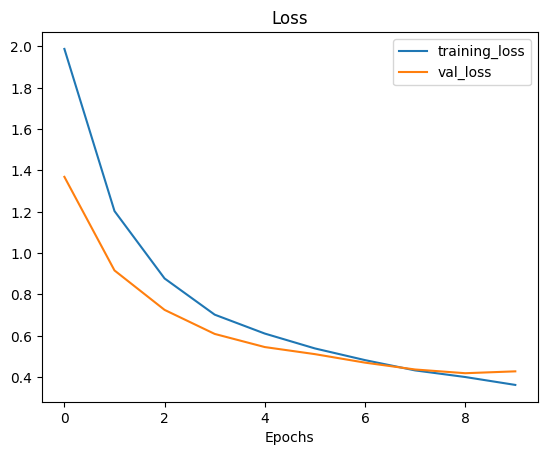

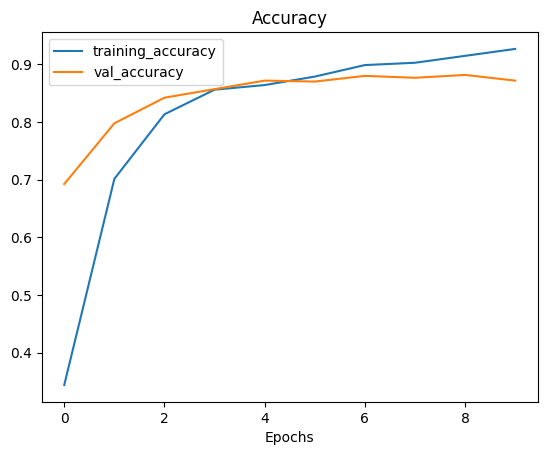

In [16]:
# Check out the training curves
plot_loss_curves(history_10_percent)

# Get a feature vector from the trained model
Demonstrating the Global Average Pooling 2D Layer:

We have a tensor of shape (None, 7, 7, 1280), which turns into (None, 1280) after passing through GlobalAveragePooling2D. It transforms a 4D (spatial) tensor into 2D (1, 3) shape.

In [17]:
# Define the input shape
input_shape = (1, 6, 6, 3)

# Create random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n{input_tensor}")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"Pooled tensor:\n{global_average_pooled_tensor}")

Random input tensor:
[[[[ 3.2746851e-01 -8.4262580e-01  3.1943369e-01]
   [-1.4075519e+00 -2.3880599e+00 -1.0392479e+00]
   [-5.5732322e-01  5.3970701e-01  1.6994323e+00]
   [ 2.8893656e-01 -1.5066116e+00 -2.6454741e-01]
   [-5.9722406e-01 -1.9171132e+00 -6.2044144e-01]
   [ 8.5040230e-01 -4.0604794e-01 -3.0258412e+00]]

  [[ 9.0584642e-01  2.9855987e-01 -2.2561555e-01]
   [-7.6164430e-01 -1.8917141e+00 -9.3847126e-01]
   [ 7.7852213e-01 -4.7338894e-01  9.7772694e-01]
   [ 2.4694404e-01  2.0573746e-01 -5.2562326e-01]
   [ 3.2410017e-01  2.5454091e-02 -1.0638496e-01]
   [-6.3694745e-01  1.1603122e+00  2.5073591e-01]]

  [[-4.1728503e-01  4.0125781e-01 -1.4145443e+00]
   [-5.9318572e-01 -1.6617213e+00  3.3567193e-01]
   [ 1.0815628e-01  2.3479679e-01 -5.6668764e-01]
   [-3.5819843e-01  8.8698614e-01  5.2744764e-01]
   [ 7.0402247e-01 -3.3421248e-01  2.1639644e-01]
   [-9.7485447e-01 -2.0757681e-01 -3.6477294e-02]]

  [[-1.3353444e+00  6.8858552e-01  1.1110831e+00]
   [ 4.0130249e-01  6.3

## Running a series of transfer learning experiments

We can try transfer learning with only 1% of the training data.

1. `model_1`: Use feature extraction transfer learning with 1% of the training data with data augmentation

2. `model_2`: Use feature extraction transfer learning with 10% of the training data with data augmentation

3. `model_3`: Use fine-tuning transfer learning on 10% of the training data with data augmentation

4. `model_4`: Use fine-tuning transfer learning on 100% of the training data with data augmentation

> **Note:** Throughout all experiments, the same test dataset will be used to evaluate our model to ensure consistency across evaluation metrics

In [ ]:
# Download and unzip data